In [1]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import model_from_json
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import splitfolders
import os
import numpy as np
from modelfunc import save_model

In [2]:
np.random.seed(123) # set random seed for reproducability

In [3]:
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU'))) # make sure GPU is being used

Num GPUs Available:  1


In [4]:
tf.get_logger().setLevel('ERROR') # hide some warning messages

#### Load Data

In [5]:
datapath='../0. Project Data/Original Data'
org_data_dir = pathlib.Path(datapath).with_suffix('')
org_data_dir

WindowsPath('../0. Project Data/Original Data')

#### Split Data into Train, Test, and Validation Sets

In [6]:
train_split_test_dir='../0. Project Data/Original Split Data'
splitfolders.ratio(org_data_dir, output=train_split_test_dir, seed=123, ratio=(.64, .16, .2)) # ratio of split are in order of train/val/test.

#### Image Parameters

In [7]:
# input image specifications
batch_size = 32
img_height = 180
img_width = 180
img_channels = 3

#### Load Datasets

In [8]:
train_ds = image_dataset_from_directory(
    train_split_test_dir + '/train',
    image_size=(img_width, img_height),
    batch_size=batch_size)
val_ds = image_dataset_from_directory(
    train_split_test_dir + '/val',
    image_size=(img_width, img_height),
    batch_size=batch_size)
test_ds = image_dataset_from_directory(
    train_split_test_dir + '/test',
    image_size=(img_width, img_height),
    batch_size=batch_size)

Found 2678 files belonging to 4 classes.
Found 667 files belonging to 4 classes.
Found 843 files belonging to 4 classes.


#### Building CNN Model

In [9]:
# engineering more data by applying randomized horizontal flips, zooms(+/- 20%), and rotates (+/- 10%)
data_augmentation = keras.Sequential([layers.RandomFlip('horizontal'), layers.RandomRotation(0.1), layers.RandomZoom(0.2),])

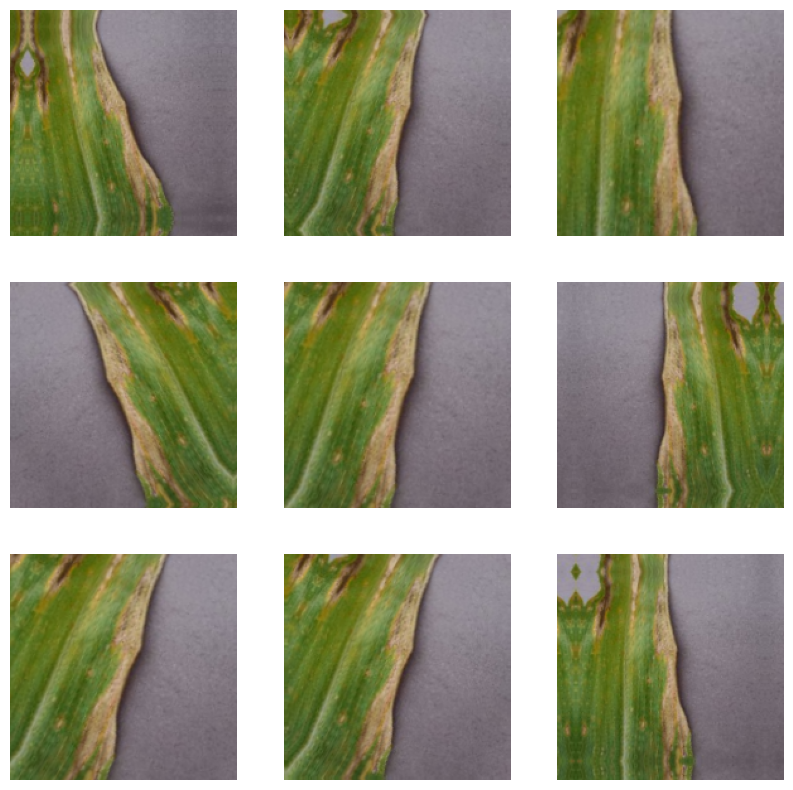

In [10]:
# data augmentation on one image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(2):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [11]:
inputs = keras.Input(shape=(img_height, img_width, img_channels))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x) # rescaling pixel values from 0-255 to 0-1
# convolution and max pooling layers
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
# flatten
x = layers.Flatten()(x)
# Dense output classification layer
outputs = layers.Dense(4, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                             

In [13]:
model.compile(optimizer='sgd', # Common optimizers include 'adam', 'sgd', and 'rmsprop'.
 loss='sparse_categorical_crossentropy', # Common loss functions include 'binary_crossentropy', 'categorical_crossentropy', and 'mse'.
 metrics=['accuracy']) #Common metrics include 'accuracy', 'precision', 'recall', and 'f1_score'.

#### Fitting the Model

In [14]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100
)

Epoch 1/100
84/84 [==============================] - 34s 349ms/step - loss: 1.3424 - accuracy: 0.3196 - val_loss: 1.3221 - val_accuracy: 0.3388
Epoch 2/100
84/84 [==============================] - 27s 318ms/step - loss: 1.2978 - accuracy: 0.4160 - val_loss: 1.2535 - val_accuracy: 0.3478
Epoch 3/100
84/84 [==============================] - 24s 286ms/step - loss: 1.2134 - accuracy: 0.4836 - val_loss: 1.2086 - val_accuracy: 0.4978
Epoch 4/100
84/84 [==============================] - 24s 281ms/step - loss: 1.1228 - accuracy: 0.5422 - val_loss: 0.9309 - val_accuracy: 0.6087
Epoch 5/100
84/84 [==============================] - 25s 297ms/step - loss: 1.0220 - accuracy: 0.5833 - val_loss: 1.1626 - val_accuracy: 0.4798
Epoch 6/100
84/84 [==============================] - 25s 299ms/step - loss: 0.9286 - accuracy: 0.6288 - val_loss: 0.9396 - val_accuracy: 0.6162
Epoch 7/100
84/84 [==============================] - 26s 305ms/step - loss: 0.8620 - accuracy: 0.6639 - val_loss: 0.6584 - val_accuracy:

84/84 [==============================] - 23s 278ms/step - loss: 0.2313 - accuracy: 0.9022 - val_loss: 0.3036 - val_accuracy: 0.8891
Epoch 58/100
84/84 [==============================] - 23s 276ms/step - loss: 0.2311 - accuracy: 0.9108 - val_loss: 0.2597 - val_accuracy: 0.8996
Epoch 59/100
84/84 [==============================] - 23s 275ms/step - loss: 0.2242 - accuracy: 0.9089 - val_loss: 0.2657 - val_accuracy: 0.8936
Epoch 60/100
84/84 [==============================] - 23s 275ms/step - loss: 0.2286 - accuracy: 0.9122 - val_loss: 0.3078 - val_accuracy: 0.8846
Epoch 61/100
84/84 [==============================] - 23s 275ms/step - loss: 0.2346 - accuracy: 0.9052 - val_loss: 0.2626 - val_accuracy: 0.8906
Epoch 62/100
84/84 [==============================] - 23s 275ms/step - loss: 0.2982 - accuracy: 0.8962 - val_loss: 0.3104 - val_accuracy: 0.8861
Epoch 63/100
84/84 [==============================] - 23s 275ms/step - loss: 0.2421 - accuracy: 0.9052 - val_loss: 0.2847 - val_accuracy: 0.889

#### Plotting Training and Validation Accuracy and Loss

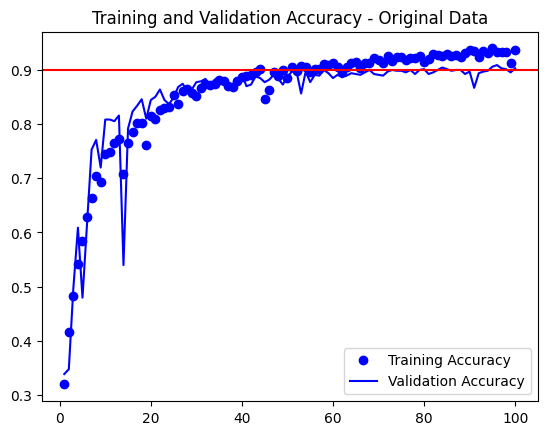

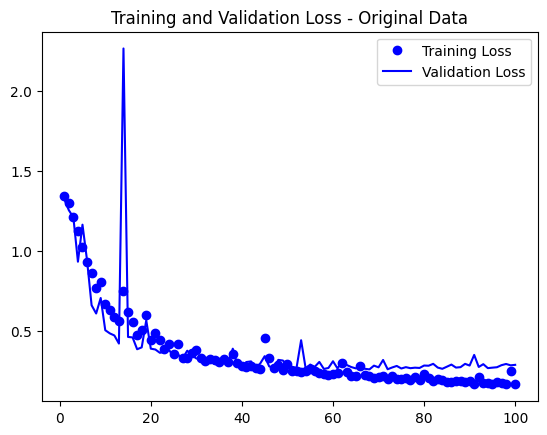

In [15]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.axhline(y=0.9, color='r', linestyle='-')
plt.title('Training and Validation Accuracy - Original Data')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss - Original Data')
plt.legend()

#### Saving the Model

In [16]:
save_path = '../3. Model Selection/saved_models/Model 1-Original Data/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
save_model(model, save_path)

Saved model to disk


In [17]:
#below saved files are gitignored

In [18]:
if not os.path.exists('./saved_models/Model 1-Original Data'):
    os.makedirs('./saved_models/Model 1-Original Data')
model.save('./saved_models/Model 1-Original Data')